In [1]:
import numpy as np
import gpflow

#It's the old package without your updates... can change after sync repository
#As such, will need to pull "master" for this to work
from thermoextrap.xtrapy import core
from thermoextrap.xtrapy import xpan_beta
from thermoextrap.xtrapy import xpan_volume
from thermoextrap.xtrapy import xpan_GPR
from thermoextrap import ig

import matplotlib.pyplot as plt

# Ideal gas comparison

In [2]:
ig_model = ig.IGmodel()

beta_ref = np.array([0.1, 9.1])

ig_states = []
for b in beta_ref:
    this_dat = ig_model.genData(b, nConfigs=10000)
    ig_states.append(xpan_beta.factory_extrapmodel(1, b, this_dat[1], this_dat[0][:, None],
                                                   xalpha=False, central=True))


In [4]:
ig_gpr = xpan_GPR.factory_rbf_gprmodel(ig_states)
ig_interp = core.InterpModel(ig_states)

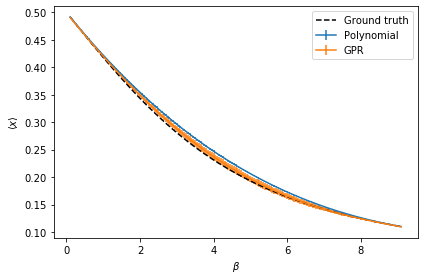

In [5]:
# %matplotlib notebook

beta_vals = np.arange(0.1, 9.15, 0.05)
avgX_vals = ig_model.avgX(beta_vals)

gpr_mu, gpr_std = ig_gpr.predict(beta_vals)
interp_mu = ig_interp.predict(beta_vals)
interp_std = ig_interp.resample(100).predict(beta_vals).std('rep')

fig, ax = plt.subplots()

ax.plot(beta_vals, avgX_vals, 'k--', label='Ground truth')
ax.errorbar(beta_vals, np.squeeze(interp_mu), yerr=np.squeeze(interp_std), marker='', label='Polynomial')
ax.errorbar(beta_vals, np.squeeze(gpr_mu), yerr=np.squeeze(gpr_std), marker='', label='GPR')

ax.legend()

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle x \rangle$')

fig.tight_layout()

plt.show()

In [6]:
#For GPR, you actually have to train the parameters, unlike with polynomial where they are just known
#Look at impact of training a little more
#First print current parameters (default training is for 100 steps)
gpflow.utilities.print_summary(ig_gpr.gp)

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.3982120988122224                                   │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.792524895063172                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────

In [7]:
#Train for another 100 steps
ig_gpr._train_GP(*ig_gpr._collect_data(), opt_steps=100)

In [8]:
#Look at parameters again
gpflow.utilities.print_summary(ig_gpr.gp)

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.39389067673714306                                  │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.747693685281748                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────

# Water density comparison

In [9]:
import sys, os
import glob
import simtk.unit as u

#Define some constants that we will use
kB = u.BOLTZMANN_CONSTANT_kB*u.AVOGADRO_CONSTANT_NA

#Figure out the files we want to work with
T = 300
beta = 1.0/(kB*T*u.kelvin).value_in_unit(u.kilojoule_per_mole)
dDirs = glob.glob('/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens*/T%iK'%T)
dDirs = sorted(dDirs)#[:-1]
print(dDirs)

#Get actual densities
dVals = [float(s.split('/')[-2][4:]) for s in dDirs]
print(dVals)

edgeVals = np.zeros(len(dVals))
#And actual edge lengths because more accurate from the gro files
for i, d in enumerate(dDirs):
    with open('%s/nvt.gro'%d, 'rb') as f:
        f.seek(-2, os.SEEK_END)     # Jump to the second last byte.
        while f.read(1) != b"\n":   # Until EOL is found...
            f.seek(-2, os.SEEK_CUR) # ...jump back the read byte plus one more.
        last = f.readline()         # Read last line.
        edgeVals[i] = float(last.strip().split()[-1])
print(edgeVals)
volVals = edgeVals**3

#Define standardized names of files
rdfHistFile = 'refT_RDF_histograms.txt'
volumeFile = 'refT_volumes.txt'
energyFile = 'energy.xvg'
rdfFile = 'refT_RDF.txt'
threeBodyHistFile = 'refT_3body_histograms.txt'
threeBodyFile = 'refT_3body.txt'
qFile = 'refT_q.txt' #Just going to work with this one, really
probeHSFile = 'refT_PofN.txt'
probeHSHistFile = 'refT_PofN_histograms.txt'


['/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.87/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.90/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.95/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.05/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.10/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.15/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.20/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.30/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.40/T300K']
[0.87, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4]
[3.6378 3.5969 3.5326 3.4727 3.4167 3.3641 3.3147 3.268  3.1819 3.1043]


In [11]:
#Collect data for the tetrahedral order parameter

refInds = [0, -1]

#Using two most extreme densities for interpolation and GPR training
interpqdat = []
interpVirialDat = []
for ind in refInds:
    compDir = dDirs[ind] #'%s/extended_2016.1'%(dDirs[ind]) #dDirs[ind]
    interpqdat.append(np.loadtxt('%s/%s'%(compDir, qFile))[:, None])
    energyDat = np.loadtxt('%s/%s'%(compDir, energyFile))
    virialDat = (-2.0)*(energyDat[:,-3] + energyDat[:,-2] + energyDat[:,-1])
    virialDat = beta*virialDat[::5] #Energies saved more frequently than structural data
    interpVirialDat.append(virialDat)

#Make numpy
interpqdat = np.array(interpqdat)
interpVirialDat = np.array(interpVirialDat)

#Save all true q values as a function of density
trueq = np.zeros(len(dDirs))

#Loop over all densities
for i in np.arange(0, len(dDirs)):
    
    print('\n\t%1.2f'%(dVals[i])+r' g/cm$^3$ :')
    
    #Load data for the average q at the density we're extrapolating to
#     try:
#         thisqDat = np.loadtxt('%s/extended_2016.1/%s'%(dDirs[i], qFile))
#         print('Using longer sim!')
#     except OSError:
    thisqDat = np.loadtxt('%s/%s'%(dDirs[i], qFile))

    thisq = np.average(thisqDat)
    thisqStd = np.std(thisqDat, ddof=1)
    trueq[i] = thisq
    
    print('\t\tTrue value: %f +/- %f'%(thisq, thisqStd))



	0.87 g/cm$^3$ :
		True value: 0.679508 +/- 0.007424

	0.90 g/cm$^3$ :
		True value: 0.683093 +/- 0.006977

	0.95 g/cm$^3$ :
		True value: 0.677332 +/- 0.006726

	1.00 g/cm$^3$ :
		True value: 0.665811 +/- 0.006081

	1.05 g/cm$^3$ :
		True value: 0.652765 +/- 0.006006

	1.10 g/cm$^3$ :
		True value: 0.639312 +/- 0.005725

	1.15 g/cm$^3$ :
		True value: 0.626090 +/- 0.005734

	1.20 g/cm$^3$ :
		True value: 0.613394 +/- 0.005515

	1.30 g/cm$^3$ :
		True value: 0.590084 +/- 0.005361

	1.40 g/cm$^3$ :
		True value: 0.569945 +/- 0.005430


In [12]:
#Define volume derivative function for q
class VolumeDerivFuncsq(object):
    """Calculates specific derivative values at refV with data x and W.
       Only go to first order for volume extrapolation.
       Here W represents the virial instead of the potential energy.
    """
    def __init__(self, refV=1.0):
        #If do not set refV, assumes virial data is already divided by the reference volume
        #If this is not the case, need to set refV
        #Or if need refV to also compute custom term, need to specify
        self.refV = refV

    def __getitem__(self, order):
        #Check to make sure not going past first order
        if order > 1:
            raise ValueError("Volume derivatives cannot go past 1st order"
                             +" and received %i"%order
                             +"\n(because would need derivatives of forces)")
        else:
            return self.create_deriv_func(order)

    def create_deriv_func(self, order):
        #Works only because of local scope
        #Even if order is defined somewhere outside of this class, won't affect returned func

        def func(W, xW):
            #Zeroth order derivative
            if order == 0:
                deriv_val =  xW[0]
            #First order derivative
            else:
                deriv_val = (xW[1] - xW[0]*W[1]) / (3*self.refV)
                #No correction term of tetrahedral order parameter q
            return deriv_val

        return func


In [13]:
#Set up ExtrapModel states
water_states = [core.ExtrapModel(alpha0=volVals[ind], data=xpan_beta.factory_data(uv=interpVirialDat[i],
                                                                                  xv=interpqdat[i],
                                                                                  order=1,
                                                                                  central=False,
                                                                                  xalpha=False), 
                                 coefs=core.Coefs(VolumeDerivFuncsq(refV=volVals[ind])),
                                 order=1, minus_log=False, alpha_name='volume')
                for i, ind in enumerate(refInds)]

#Create interpolation and GPR models
water_interp = core.InterpModel(water_states)
water_gpr = xpan_GPR.factory_rbf_gprmodel(water_states)

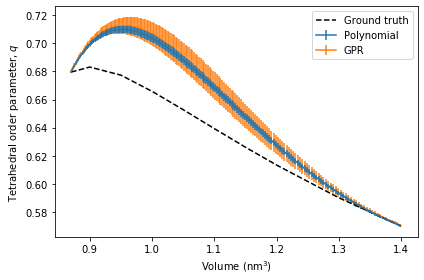

In [19]:
# %matplotlib notebook

vol_vals = np.arange(volVals[0], volVals[-1], -0.1)
dens_vals = 1400.0 / (vol_vals*(u.nanometer**3))
#Need to convert units
dens_vals *= (18.016 * (u.gram / u.mole) / u.AVOGADRO_CONSTANT_NA)
dens_vals = dens_vals.value_in_unit(u.gram / (u.centimeter**3))

gpr_mu, gpr_std = water_gpr.predict(vol_vals)
interp_mu = water_interp.predict(vol_vals)
interp_std = water_interp.resample(100).predict(vol_vals).std('rep')

fig, ax = plt.subplots()

ax.plot(dVals, trueq, 'k--', label='Ground truth')
ax.errorbar(dens_vals, np.squeeze(interp_mu), yerr=np.squeeze(interp_std), marker='', label='Polynomial')
ax.errorbar(dens_vals, np.squeeze(gpr_mu), yerr=np.squeeze(gpr_std), marker='', label='GPR', zorder=0)

ax.legend()

ax.set_xlabel(r'Volume (nm$^3$)')
ax.set_ylabel(r'Tetrahedral order parameter, $q$')

fig.tight_layout()

plt.show()

In [16]:
#For GPR, you actually have to train the parameters, unlike with polynomial where they are just known
#Look at impact of training a little more
#First print current parameters (default training is for 100 steps)
gpflow.utilities.print_summary(water_gpr.gp)

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.22675974226653092                                  │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 16.648847813873125                                   │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────

In [17]:
#Train for another 100 steps
water_gpr._train_GP(*water_gpr._collect_data(), opt_steps=100)

In [18]:
#Look at parameters again
gpflow.utilities.print_summary(water_gpr.gp)

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.23296090681020928                                  │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 16.782050004167914                                   │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────